In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum().sum()
test.isnull().sum().sum()

### outlier

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])
df.shape

(32561, 14)

In [7]:
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

In [8]:
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

,education_num,capital_gain_imsi
0,1,898.392157
1,2,125.875000
2,3,176.021021
3,4,233.939628
4,5,147.538911
5,6,190.214362
6,7,215.097872
7,8,284.087760
8,9,357.775545
9,10,406.808531


In [9]:
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

In [10]:
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

In [11]:
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

#### marital_status  encoding

In [21]:
train['marital_status_int']=pd.factorize(train['marital_status'], sort=True)[0]
test['marital_status_int']=pd.factorize(test['marital_status'], sort=True)[0]

In [22]:
train['marital_status_n_rows'] = train['marital_status_int'].map(train.groupby('marital_status_int').size())
test['marital_status_n_rows'] = test['marital_status_int'].map(test.groupby('marital_status_int').size())

In [23]:
marital_status_mean = train.groupby('marital_status_int')['income'].mean()
train['marital_status_mean'] = train['marital_status_int'].map(marital_status_mean)
test['marital_status_mean'] = test['marital_status_int'].map(marital_status_mean)

In [24]:
#train['income'].mean()# = 0.242043840454528
def smoothing(n_rows, target_mean): 
    return (target_mean*n_rows + 0.242043840454528*0.8) / (n_rows + 0.8)

In [25]:
train['marital_status_mean_smoothing'] = train.apply(lambda x:smoothing(x['marital_status_n_rows'], x['marital_status_mean']), axis=1)
test['marital_status_mean_smoothing'] = test.apply(lambda x:smoothing(x['marital_status_n_rows'], x['marital_status_mean']), axis=1)

In [26]:
train.drop(['marital_status_int','marital_status_mean', 'marital_status_n_rows'], axis=1, inplace=True)
test.drop(['marital_status_int','marital_status_mean', 'marital_status_n_rows'], axis=1, inplace=True)

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [27]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 16.8 s


In [28]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8657,0.9210,0.6468,0.7626,0.6997,0.6140,0.6176,0.2863
1,CatBoost Classifier,0.8659,0.9238,0.6387,0.7686,0.6973,0.6121,0.6167,10.7642
2,Extreme Gradient Boosting,0.8634,0.9202,0.6462,0.7551,0.6961,0.6087,0.6120,2.0787
3,Gradient Boosting Classifier,0.8626,0.9185,0.6050,0.7782,0.6805,0.5947,0.6026,1.9831
4,Ada Boost Classifier,0.8564,0.9118,0.6248,0.7414,0.6780,0.5864,0.5901,0.7833
5,Linear Discriminant Analysis,0.8460,0.9000,0.5927,0.7216,0.6504,0.5529,0.5576,0.1812
6,Extra Trees Classifier,0.8366,0.8835,0.6031,0.6848,0.6411,0.5359,0.5378,0.5204
7,Random Forest Classifier,0.8390,0.8759,0.5549,0.7178,0.6253,0.5249,0.5324,0.1264


In [29]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8660,0.9212,0.6375,0.7695,0.6973,0.6123,0.6168
1,0.8602,0.9158,0.6375,0.7476,0.6882,0.5988,0.6020
2,0.8566,0.9217,0.6230,0.7432,0.6778,0.5865,0.5903
3,0.8762,0.9297,0.6451,0.8040,0.7158,0.6379,0.6442
4,0.8687,0.9246,0.6553,0.7685,0.7074,0.6235,0.6268
Mean,0.8655,0.9226,0.6397,0.7666,0.6973,0.6118,0.6160
SD,0.0068,0.0045,0.0106,0.0215,0.0135,0.0180,0.0188


In [30]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8726,0.9293,0.6586,0.7807,0.7145,0.6332,0.637


In [31]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 5s


In [32]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [33]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [34]:
submission.to_csv('output/20201016-4.csv')

In [35]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8590,0.9166,0.5858,0.7768,0.6679,0.5807,0.5900
1,0.8606,0.9143,0.6278,0.7549,0.6855,0.5969,0.6011
2,0.8583,0.9103,0.6181,0.7520,0.6785,0.5887,0.5934
3,0.8589,0.9069,0.5974,0.7667,0.6715,0.5835,0.5908
4,0.8558,0.9106,0.5922,0.7593,0.6655,0.5753,0.5825
5,0.8652,0.9287,0.6019,0.7915,0.6838,0.6002,0.6093
6,0.8707,0.9377,0.5987,0.8186,0.6916,0.6123,0.6242
7,0.8589,0.9195,0.5858,0.7768,0.6679,0.5806,0.5899
8,0.8605,0.9212,0.5858,0.7835,0.6704,0.5842,0.5942
9,0.8777,0.9187,0.6570,0.8024,0.7224,0.6450,0.6503


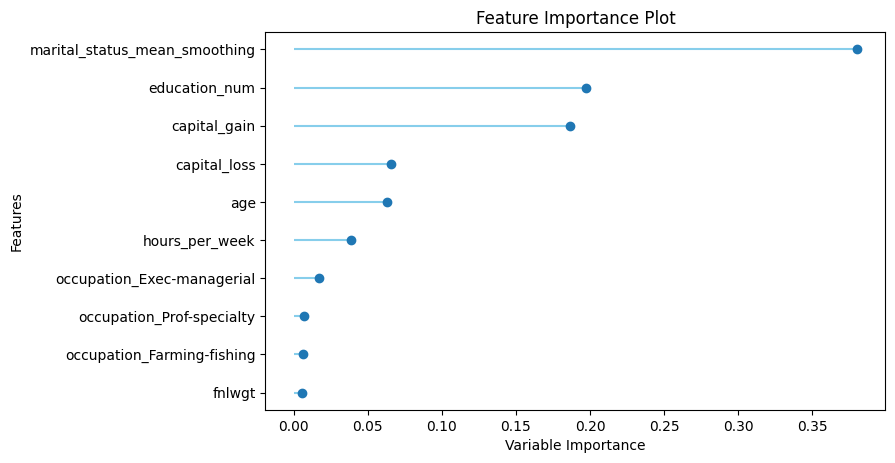

In [36]:
plot_model(estimator = gbc, plot = 'feature')

In [37]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8684,0.9195,0.6343,0.7809,0.7000,0.6169,0.6224
1,0.8559,0.9168,0.6505,0.7256,0.6860,0.5929,0.5944
2,0.8653,0.9177,0.6731,0.7455,0.7075,0.6203,0.6217
3,0.8511,0.9137,0.6234,0.7218,0.6690,0.5736,0.5762
4,0.8448,0.9039,0.6117,0.7079,0.6562,0.5567,0.5592
5,0.8699,0.9284,0.6570,0.7719,0.7098,0.6266,0.6300
6,0.8777,0.9365,0.6505,0.8072,0.7204,0.6433,0.6495
7,0.8652,0.9240,0.6343,0.7686,0.6950,0.6095,0.6142
8,0.8636,0.9231,0.6440,0.7567,0.6958,0.6087,0.6119
9,0.8723,0.9188,0.6828,0.7645,0.7214,0.6388,0.6406


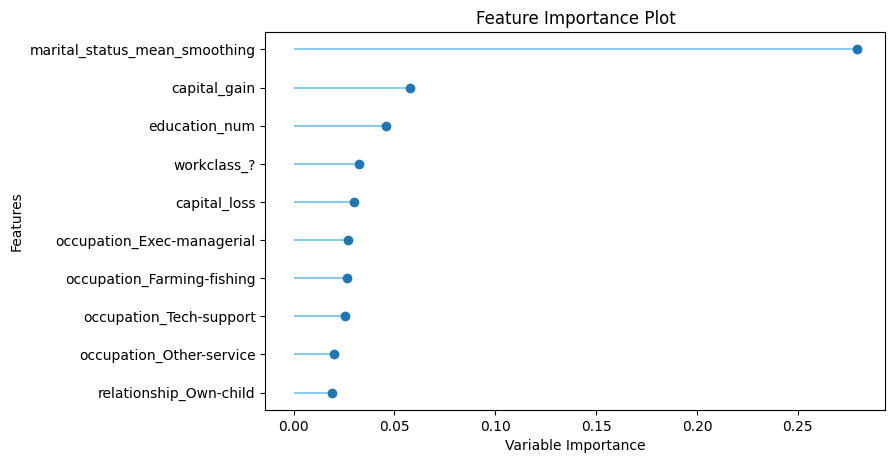

In [38]:
plot_model(estimator = xgboost, plot = 'feature')

In [39]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8598,0.9220,0.6149,0.7600,0.6798,0.5913,0.5968
1,0.8630,0.9175,0.6602,0.7445,0.6998,0.6115,0.6133
2,0.8637,0.9170,0.6699,0.7419,0.7041,0.6159,0.6172
3,0.8558,0.9139,0.6266,0.7366,0.6772,0.5851,0.5883
4,0.8527,0.9103,0.6149,0.7336,0.6690,0.5752,0.5789
5,0.8723,0.9306,0.6602,0.7786,0.7145,0.6330,0.6365
6,0.8817,0.9367,0.6699,0.8086,0.7327,0.6576,0.6624
7,0.8652,0.9183,0.6311,0.7708,0.6940,0.6086,0.6136
8,0.8676,0.9251,0.6408,0.7734,0.7009,0.6168,0.6213
9,0.8754,0.9189,0.6796,0.7778,0.7254,0.6453,0.6477


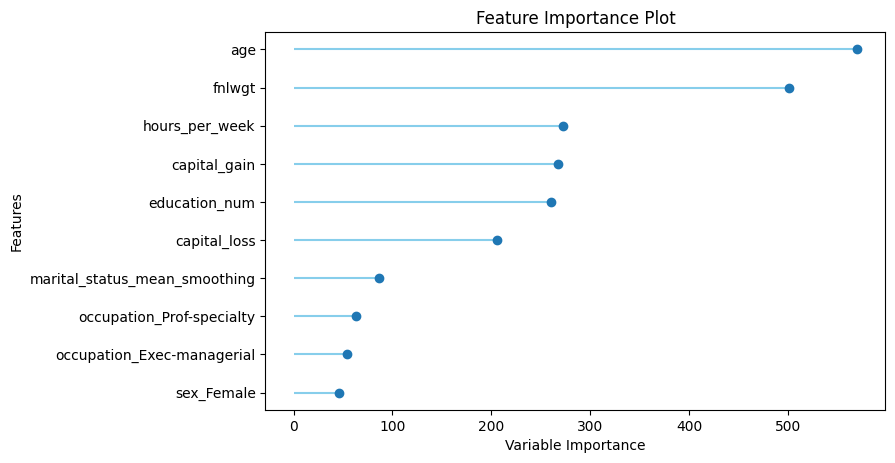

In [40]:
plot_model(estimator = lightgbm, plot = 'feature')